# Real or Not? NLP with Disaster Tweets
## Daniel Díez Mallo
### https://www.linkedin.com/in/danieldiezmallo/

This notebook contains the code used to solve the Kaggle challenge "Real or Not? NLP with Disaster Tweets", avialable in https://www.kaggle.com/c/nlp-getting-started. In it, a set of tweets that refer to different disasters is provided, being some of them real and some fake. The objectives is, using supervised learning and NLP, to correctly classify new tweets in real or fake, based on the text of the tweet, location or keywords.

## 1. Import and observe dataset

In [15]:
# Load libraires for data wrangling
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# Set seed for reproducibility
np.random.seed(5)

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("Number of tweets in train %s " % (len(train)))
print("Number of tweets in test %s " % (len(test)))

# Visualize head and a summary of numerical values of train data
print("------------train data head------------")
print(train.head(5))
print("------------train data summary------------")
print(train.describe())
print("------------train data missing counts------------")
print("Tweets missing keywords:", np.sum(train['keyword'].isna()))
print("Tweets missing location:", np.sum(train['location'].isna()))
print("Tweets missing text:", np.sum(train['text'].isna()))

Number of tweets in train 7613 
Number of tweets in test 3263 
------------train data head------------
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
------------train data summary------------
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
------------train data missing 

The data consists of a text, that corresponds to the data, and a label that indicates whether the tweet is referring to a real disaster or not. It also contains the location of the tweet if it is available, and the keyword that the tweet may have if available.

It is possible to see as well that, out 7613 tweets in the training, 61 of them are missing the keyword, and 2533 are missing the location, and none of them are missing the text. This is the reason why the main source where features for model training will be extracted is the text of the tweet.

## 2. Tokenize and lemmatize the tweets

It is necesary in order to be able to statisticly model the text of the tweets to tokenize the words contained in the text, and convert them into numerical features that can be understood by a computer.

In order to do so, a function is going to be defined, that takes all the text contained in the tweets, tokenizes it and reduces every single one of the words into the stem, so all words and their derivations are counted as the same word.

It is also necesary to look for mentions, hashtags and links that can be contained in the tweets, as these tokens need a different proccesing and need to be identified first.

In [16]:
import re
from nltk.stem.snowball import SnowballStemmer
# Initialize stemmer object
stemmer = SnowballStemmer("english")
# Define a function to perform both stemming and tokenization
def remove_noise_and_tokenize(text):
    """Grid to find best parameters for model and plot heatmap 2D
    
    Arguments:
    ----------
    model: scikit-learn like model
    
    X: train data (np.array)
        
    y: train labels (np.array)
        
    plots the heatmap
    
    returns best model
    """
    # Lowercase all data
    text = text.lower()
    # Unwanted characters are removed
    text = re.sub('\[.*?\]', '', text) # substitutes text between aquare brackets
    text = re.sub('https?://\S+|www\.\S+', 'https', text) # Remove links
    text = re.sub('<.*?>+', '', text) # Substitutes everything between <>>>
    text = re.sub('\n', '', text) # Remove line breaks
    text = re.sub('\w*\d\w*', '', text) # Remove digits and letters around digits
    # Tokenize by sentence, then by word
    tokens = [word for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)]
    # Filter out raw tokens to remove noise

    # Stem the filtered_tokens
    tokens = [stemmer.stem(word) for word in tokens]
    # print(tokens)

    return tokens

This function will then be used to create a Tfidf vector that gives all of the identified tokens a score based on how many times they appear in the tweet they are in, and among the tweets, so very common words are not taken into account as much as words that are unique to some tweets or less uncommon than the rest.

## 3. Create a TfidfVectorizer

In this section, both the training and test text datasets are going to be converted into a set of word vectors. The objective of this step is to create a statistical quantification of the meaning of the words contained in all of the tweets. This way, it is possible to create a set of features that can then be fed to a supervised learning algorithm to create a model.

One approach to this problem, is to simply count the number of words that appear, and use this count vectorizer as the imput. However, it was decided to use a "term frecuency inverse document frecuency" vector, of TFID vector. It gives each word a score based on how many times it appears in a document or tweet, but it also pensalizes the words that appear in a lot of documents. This way, the most relevant words would be those that appear a lot in a tweet, but do not appear in many of them.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Create a vectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=5000, # max features to evaluate
                                    max_df=0.7, # drops words that appear in this percentage of the documents (topic stopwprds)
                                    stop_words='english',
                                    use_idf=True, # enable inverse frecuency
                                    tokenizer=remove_noise_and_tokenize # function to tokenize the words in a document
                                    )

In [18]:
# Fit the TFIDF vector with the text in the training data and transform it
train_tfidf_matrix = tfidf_vectorizer.fit_transform(train['text'])

# Transform the test data into another vecor for the predictions
test_tfidf_matrix = tfidf_vectorizer.transform(test['text'])

print(train_tfidf_matrix.shape)
print(test_tfidf_matrix.shape)

(7613, 5000)
(3263, 5000)


Now that the vectorizer has been created and a tfidf score has been given to each word, it is possible to examine them, by creating a Pandas DataFrame. It is possible to see that the least scored tokens are the ones corresponding to links, mentions and hashtags, as these appear in many of the documents.

In [19]:
features = pd.DataFrame(
                        zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_), 
                        columns=['word', 'tfidf']
                        )
features = features.sort_values(by=['tfidf'], ascending=False)
print(features)

word     tfidf
1344      dye  9.244597
502     blitz  9.244597
2934      nba  9.244597
4053  snowden  9.244597
1247    divid  9.244597
...       ...       ...
49          :  2.524980
1           #  2.464675
55          @  2.317039
32          .  2.277158
2072    https  1.665684

[5000 rows x 2 columns]


## 4. Create train and test data and labels

In this section, data is divided into target and labels

In [20]:
y_train = train['target']

x_train = train_tfidf_matrix.todense()
x_test = test_tfidf_matrix.todense()

## 5. Model training and selection

In this section a supervised learning will be trained, using different parameter combinations. Its performance will then be evaluated by cross validation in 5 folds. As there are no target labels available for the test data, it is not possible to establish what the performance of the algorithm is when it is used with new data. For each best model, the best average cross validation score will be printed.



In [21]:
from sklearn.model_selection import GridSearchCV

def fit_model_GridSearchCV(model, X_, y_, param_grid):    
    """Function to find best parameters for a model in a 2 parametere grid
    
    Arguments:
    ----------
    model: scikit-learn like model
    
    X: train data (np.array)
        
    y: train labels (np.array)
    
    returns best model
    """
    # Fit to data and find the best parameters for this estimator
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, n_jobs=-1, verbose=2)
    grid_search.fit(X_, y_)
    best_model = grid_search.best_estimator_

    print("Best model parameters: ", grid_search.best_params_)
    print("Best model train score on cross validation:", grid_search.best_score_)

    return {
            'model': best_model, 
            'score': grid_search.best_score_}
      # Return best model for future use

models = []

The first approach will be to create a simple Naive Bayes model.

In [22]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
param_grid = {
                'alpha': np.arange(0,1.2,0.2)
            }

print("------------ MultinomialNB ------------")
models.append(fit_model_GridSearchCV(model, x_train, y_train, param_grid))
print("---------------------------------------")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
------------ MultinomialNB ------------
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   39.7s finished
Best model parameters:  {'alpha': 0.4}
Best model train score on cross validation: 0.7405756804823874
---------------------------------------


In [23]:
from sklearn.svm import SVC

model = SVC(kernel='linear', cache_size=7000)
param_grid = {
                'C': [0.5,1,2],
                'gamma': ['scale']
            }

model_SVC = fit_model_GridSearchCV(model, x_train, y_train, param_grid)
print("------------ SVC ------------")
models.append(fit_model_GridSearchCV(model, x_train, y_train, param_grid))
print("---------------------------------------")

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 65.4min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 65.4min remaining:    0.0s
Best model parameters:  {'C': 0.5, 'gamma': 'scale'}
Best model train score on cross validation: 0.7132547514539184
------------ SVC ------------
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 63.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 63.8min finished
Best model parameters:  {'C': 0.5, 'gamma': 'scale'}
Best model train score on cross validation: 0.7132547514539184


TypeError: list indices must be integers or slices, not str

Now, the best model of all the models that were created in the previous steps is slected.

In [24]:
print(models)
scores = [model['score'] for model in models]
model = models[scores.index(max(scores))]['model']
model_score = scores[scores.index(max(scores))]
print("Best model: ", model)
print("Best model train score on cross validation:", model_score)

[{'model': MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True), 'score': 0.7405756804823874}]
Best model:  MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True)
Best model train score on cross validation: 0.7405756804823874


## 6. Create and save predictions for submission

In this section, the model is used to predict the target labels on the test data. The results will be saved in a csv file, that will be uploaded into the Kaggle competion for evaluation.

In [25]:
# Train the model with the best parameters
model.fit(x_train, y_train)

# Create a DataFrame for to store the submissions
submission = pd.DataFrame(test['id'])

# Add the predictions on test data to the submissions dataframe
submission['target'] = model.predict(x_test)

# Save the submissions
submission.to_csv("submission.csv", index=False)

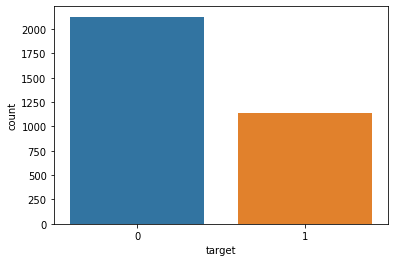

In [26]:
# Plot info on the submissions

ax = sns.countplot(x='target', data=submission)

## 7. Competition results

When submited to the Kaggle competion, the results obtained in this notebook scored a 0.79681, on a 46% percentile.